In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=3

In [3]:
print FOLD

3


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   
                    
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199329, 2) (51411, 2)
train/valid # (199329, 2) (51411, 2)
rand split across time
train has 199329 records out of 389630 records
valid has 51411 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1557
0
(199329, 1, 32) (199329, 7, 32) (199329, 1) (199329, 1)
(199329, 256) (199329,) (199329,)
(51411, 1, 32) (51411, 7, 32) (51411, 1) (51411, 1)
(51411, 256) (51411,) (51411,)
(5803, 1, 32) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 256) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38495	valid-rmse:2.4283
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.980895	valid-rmse:1.00426
[100]	train-rmse:0.57298	valid-rmse:0.596159
[150]	train-rmse:0.489396	valid-rmse:0.516974
[200]	train-rmse:0.47335	valid-rmse:0.505102
[250]	train-rmse:0.468147	valid-rmse:0.503352
[300]	train-rmse:0.464051	valid-rmse:0.503129
[350]	train-rmse:0.46073	valid-rmse:0.50321
Stopping. Best iteration:
[301]	train-rmse:0.463978	valid-rmse:0.503119

0.21527576 0.25312847
[0.25312847]
-1 mean score 0.25312847
0.193069115281


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919343  0.009767  0.198441    7  2017-04-16
472     2.507290  2.532814 -0.025524  0.205315    1  2017-04-17
473     2.661330  2.657658  0.003671  0.227554    2  2017-04-18
474     2.754815  2.741073  0.013741  0.189686    3  2017-04-19
475     2.713762  2.704447  0.009315  0.222775    4  2017-04-20
476     2.999000  2.980830  0.018170  0.140568    5  2017-04-21
477     3.075529  3.077408 -0.001879  0.167144    6  2017-04-22

0.193069115281


pred         y     error    error2  day        date
dayidx                                                         
471     2.919343  2.929110  0.009767  0.198441    7  2017-04-16
472     2.532814  2.507290 -0.025524  0.205315    1  2017-04-17
473     2.657658  2.661330  0.003671  0.227554    2  2017-04-18
474     2.741073  2.754815  0.013741  0.189686    3  2017-04-19
475     2.704447  2.713762  0.009315  0.222775    4  2017-04-20
476     2.980830  2.999000  0.018170  0.140568    5  2017-04-21
477     3.077408  3.075529 -0.001879  0.167144    6  2017-04-22

(829, 256)


In [26]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199102, 2) (51355, 2)
train/valid # (199102, 2) (51355, 2)
rand split across time
train has 199102 records out of 389630 records
valid has 51355 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1555
0
(199102, 1, 32) (199102, 7, 32) (199102, 1) (199102, 1)
(199102, 256) (199102,) (199102,)
(51355, 1, 32) (51355, 7, 32) (51355, 1) (51355, 1)
(51355, 256) (51355,) (51355,)
(6632, 1, 32) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 256) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38477	valid-rmse:2.42835
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.9847	valid-rmse:1.01016
[100]	train-rmse:0.57872	valid-rmse:0.603413
[150]	train-rmse:0.494662	valid-rmse:0.523029
[200]	train-rmse:0.47793	valid-rmse:0.510146
[250]	train-rmse:0.471732	valid-rmse:0.508017
[300]	train-rmse:0.467372	valid-rmse:0.507516
[350]	train-rmse:0.463477	valid-rmse:0.507508
[400]	train-rmse:0.460007	valid-rmse:0.507407
[450]	train-rmse:0.456762	valid-rmse:0.507463
Stopping. Best iteration:
[402]	train-rmse:0.459907	valid-rmse:0.507402

0.21151452 0.25745645
[0.25745645]
-1 mean score 0.25745645
0.192136839032


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916344  0.012766  0.201809    7  2017-04-16
472     2.507290  2.538607 -0.031317  0.206873    1  2017-04-17
473     2.661330  2.656648  0.004682  0.225804    2  2017-04-18
474     2.754815  2.738259  0.016555  0.188574    3  2017-04-19
475     2.713762  2.713139  0.000623  0.217402    4  2017-04-20
476     2.999000  2.987600  0.011400  0.139853    5  2017-04-21
477     3.075529  3.070623  0.004906  0.164642    6  2017-04-22

0.192136839032


pred         y     error    error2  day        date
dayidx                                                         
471     2.916344  2.929110  0.012766  0.201809    7  2017-04-16
472     2.538607  2.507290 -0.031317  0.206873    1  2017-04-17
473     2.656648  2.661330  0.004682  0.225804    2  2017-04-18
474     2.738259  2.754815  0.016555  0.188574    3  2017-04-19
475     2.713139  2.713762  0.000623  0.217402    4  2017-04-20
476     2.987600  2.999000  0.011400  0.139853    5  2017-04-21
477     3.070623  3.075529  0.004906  0.164642    6  2017-04-22

(829, 256)


3
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198922, 2) (51308, 2)
train/valid # (198922, 2) (51308, 2)
rand split across time
train has 198922 records out of 389630 records
valid has 51308 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1554
0
(198922, 1, 32) (198922, 7, 32) (198922, 1) (198922, 1)
(198922, 256) (198922,) (198922,)
(51308, 1, 32) (51308, 7, 32) (51308, 1) (51308, 1)
(51308, 256) (51308,) (51308,)
(7461, 1, 32) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 256) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38454	valid-rmse:2.42817
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.985709	valid-rmse:1.00992
[100]	train-rmse:0.580854	valid-rmse:0.604175
[150]	train-rmse:0.497299	valid-rmse:0.524554
[200]	train-rmse:0.480514	valid-rmse:0.511929
[250]	train-rmse:0.474256	valid-rmse:0.509839
[300]	train-rmse:0.47023	valid-rmse:0.509368
[350]	train-rmse:0.466683	valid-rmse:0.50926
[400]	train-rmse:0.463633	valid-rmse:0.509273
Stopping. Best iteration:
[358]	train-rmse:0.466204	valid-rmse:0.509237

0.2173457 0.259322
[0.259322]
-1 mean score 0.259322
0.197683900595


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899181  0.029929  0.210129    7  2017-04-16
472     2.507290  2.528472 -0.021181  0.207841    1  2017-04-17
473     2.661330  2.641491  0.019839  0.239040    2  2017-04-18
474     2.754815  2.749681  0.005134  0.198946    3  2017-04-19
475     2.713762  2.710500  0.003262  0.214928    4  2017-04-20
476     2.999000  2.987799  0.011200  0.143054    5  2017-04-21
477     3.075529  3.070559  0.004970  0.169849    6  2017-04-22

0.197683900595


pred         y     error    error2  day        date
dayidx                                                         
471     2.899181  2.929110  0.029929  0.210129    7  2017-04-16
472     2.528472  2.507290 -0.021181  0.207841    1  2017-04-17
473     2.641491  2.661330  0.019839  0.239040    2  2017-04-18
474     2.749681  2.754815  0.005134  0.198946    3  2017-04-19
475     2.710500  2.713762  0.003262  0.214928    4  2017-04-20
476     2.987799  2.999000  0.011200  0.143054    5  2017-04-21
477     3.070559  3.075529  0.004970  0.169849    6  2017-04-22

(829, 256)


4
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198759, 2) (51269, 2)
train/valid # (198759, 2) (51269, 2)
rand split across time
train has 198759 records out of 389630 records
valid has 51269 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1552
0
(198759, 1, 32) (198759, 7, 32) (198759, 1) (198759, 1)
(198759, 256) (198759,) (198759,)
(51269, 1, 32) (51269, 7, 32) (51269, 1) (51269, 1)
(51269, 256) (51269,) (51269,)
(8290, 1, 32) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 256) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38453	valid-rmse:2.42832
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.986707	valid-rmse:1.01089
[100]	train-rmse:0.582428	valid-rmse:0.605795
[150]	train-rmse:0.49894	valid-rmse:0.526414
[200]	train-rmse:0.482114	valid-rmse:0.513945
[250]	train-rmse:0.475764	valid-rmse:0.511914
[300]	train-rmse:0.471982	valid-rmse:0.51147
[350]	train-rmse:0.468616	valid-rmse:0.511342
[400]	train-rmse:0.465128	valid-rmse:0.511311
Stopping. Best iteration:
[386]	train-rmse:0.466255	valid-rmse:0.511291

0.21739395 0.26141834
[0.26141834]
-1 mean score 0.26141834
0.195595309138


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901781  0.027329  0.211108    7  2017-04-16
472     2.507290  2.520878 -0.013588  0.207186    1  2017-04-17
473     2.661330  2.640492  0.020838  0.233003    2  2017-04-18
474     2.754815  2.732102  0.022713  0.195112    3  2017-04-19
475     2.713762  2.714349 -0.000588  0.217167    4  2017-04-20
476     2.999000  2.979510  0.019490  0.141129    5  2017-04-21
477     3.075529  3.065813  0.009717  0.164462    6  2017-04-22

0.195595309138


pred         y     error    error2  day        date
dayidx                                                         
471     2.901781  2.929110  0.027329  0.211108    7  2017-04-16
472     2.520878  2.507290 -0.013588  0.207186    1  2017-04-17
473     2.640492  2.661330  0.020838  0.233003    2  2017-04-18
474     2.732102  2.754815  0.022713  0.195112    3  2017-04-19
475     2.714349  2.713762 -0.000588  0.217167    4  2017-04-20
476     2.979510  2.999000  0.019490  0.141129    5  2017-04-21
477     3.065813  3.075529  0.009717  0.164462    6  2017-04-22

(829, 256)


5
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198558, 2) (51218, 2)
train/valid # (198558, 2) (51218, 2)
rand split across time
train has 198558 records out of 389630 records
valid has 51218 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1551
0
(198558, 1, 32) (198558, 7, 32) (198558, 1) (198558, 1)
(198558, 256) (198558,) (198558,)
(51218, 1, 32) (51218, 7, 32) (51218, 1) (51218, 1)
(51218, 256) (51218,) (51218,)
(9119, 1, 32) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 256) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38474	valid-rmse:2.42858
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987842	valid-rmse:1.0121
[100]	train-rmse:0.583764	valid-rmse:0.60694
[150]	train-rmse:0.500244	valid-rmse:0.52739
[200]	train-rmse:0.483339	valid-rmse:0.514706
[250]	train-rmse:0.477053	valid-rmse:0.512493
[300]	train-rmse:0.473503	valid-rmse:0.512141
[350]	train-rmse:0.470076	valid-rmse:0.512057
[400]	train-rmse:0.466298	valid-rmse:0.512089
Stopping. Best iteration:
[366]	train-rmse:0.468821	valid-rmse:0.512028

0.2197927 0.2621729
[0.2621729]
-1 mean score 0.2621729
0.197316884995


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902846  0.026264  0.206420    7  2017-04-16
472     2.507290  2.523941 -0.016651  0.212599    1  2017-04-17
473     2.661330  2.632261  0.029069  0.235970    2  2017-04-18
474     2.754815  2.731674  0.023141  0.194457    3  2017-04-19
475     2.713762  2.706484  0.007278  0.220764    4  2017-04-20
476     2.999000  2.979667  0.019333  0.143555    5  2017-04-21
477     3.075529  3.066726  0.008803  0.167455    6  2017-04-22

0.197316884995


pred         y     error    error2  day        date
dayidx                                                         
471     2.902846  2.929110  0.026264  0.206420    7  2017-04-16
472     2.523941  2.507290 -0.016651  0.212599    1  2017-04-17
473     2.632261  2.661330  0.029069  0.235970    2  2017-04-18
474     2.731674  2.754815  0.023141  0.194457    3  2017-04-19
475     2.706484  2.713762  0.007278  0.220764    4  2017-04-20
476     2.979667  2.999000  0.019333  0.143555    5  2017-04-21
477     3.066726  3.075529  0.008803  0.167455    6  2017-04-22

(829, 256)


6
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 15.133374
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198349, 2) (51164, 2)
train/valid # (198349, 2) (51164, 2)
rand split across time
train has 198349 records out of 389630 records
valid has 51164 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1549
0
(198349, 1, 32) (198349, 7, 32) (198349, 1) (198349, 1)
(198349, 256) (198349,) (198349,)
(51164, 1, 32) (51164, 7, 32) (51164, 1) (51164, 1)
(51164, 256) (51164,) (51164,)
(9948, 1, 32) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 256) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38488	valid-rmse:2.42872
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987808	valid-rmse:1.01165
[100]	train-rmse:0.583519	valid-rmse:0.607275
[150]	train-rmse:0.499812	valid-rmse:0.528249
[200]	train-rmse:0.4831	valid-rmse:0.515855
[250]	train-rmse:0.477081	valid-rmse:0.513751
[300]	train-rmse:0.473267	valid-rmse:0.51347
[350]	train-rmse:0.469821	valid-rmse:0.513323
[400]	train-rmse:0.466652	valid-rmse:0.513376
Stopping. Best iteration:
[359]	train-rmse:0.469202	valid-rmse:0.513307

0.22015023 0.26348376
[0.26348376]
-1 mean score 0.26348376
0.200912624598


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913927  0.015183  0.218762    7  2017-04-16
472     2.507290  2.534686 -0.027395  0.216139    1  2017-04-17
473     2.661330  2.635023  0.026307  0.239128    2  2017-04-18
474     2.754815  2.730009  0.024806  0.195192    3  2017-04-19
475     2.713762  2.713448  0.000313  0.223751    4  2017-04-20
476     2.999000  2.972165  0.026835  0.145582    5  2017-04-21
477     3.075529  3.080418 -0.004889  0.167835    6  2017-04-22

0.200912624598


pred         y     error    error2  day        date
dayidx                                                         
471     2.913927  2.929110  0.015183  0.218762    7  2017-04-16
472     2.534686  2.507290 -0.027395  0.216139    1  2017-04-17
473     2.635023  2.661330  0.026307  0.239128    2  2017-04-18
474     2.730009  2.754815  0.024806  0.195192    3  2017-04-19
475     2.713448  2.713762  0.000313  0.223751    4  2017-04-20
476     2.972165  2.999000  0.026835  0.145582    5  2017-04-21
477     3.080418  3.075529 -0.004889  0.167835    6  2017-04-22

(829, 256)


7
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 16.310143
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198132, 2) (51107, 2)
train/valid # (198132, 2) (51107, 2)
rand split across time
train has 198132 records out of 389630 records
valid has 51107 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1547
0
(198132, 1, 32) (198132, 7, 32) (198132, 1) (198132, 1)
(198132, 256) (198132,) (198132,)
(51107, 1, 32) (51107, 7, 32) (51107, 1) (51107, 1)
(51107, 256) (51107,) (51107,)
(10777, 1, 32) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 256) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38498	valid-rmse:2.42901
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.98919	valid-rmse:1.0128
[100]	train-rmse:0.586027	valid-rmse:0.608617
[150]	train-rmse:0.503035	valid-rmse:0.529899
[200]	train-rmse:0.486477	valid-rmse:0.51753
[250]	train-rmse:0.480439	valid-rmse:0.515621
[300]	train-rmse:0.476627	valid-rmse:0.515301
[350]	train-rmse:0.473098	valid-rmse:0.51527
Stopping. Best iteration:
[316]	train-rmse:0.475461	valid-rmse:0.515256

0.22606283 0.26548865
[0.26548865]
-1 mean score 0.26548865
0.205666229129


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909870  0.019240  0.216641    7  2017-04-16
472     2.507290  2.545337 -0.038046  0.224571    1  2017-04-17
473     2.661330  2.642248  0.019082  0.245171    2  2017-04-18
474     2.754815  2.726326  0.028489  0.200880    3  2017-04-19
475     2.713762  2.704631  0.009130  0.230369    4  2017-04-20
476     2.999000  2.974776  0.024224  0.148475    5  2017-04-21
477     3.075529  3.088946 -0.013417  0.173556    6  2017-04-22

0.205666229129


pred         y     error    error2  day        date
dayidx                                                         
471     2.909870  2.929110  0.019240  0.216641    7  2017-04-16
472     2.545337  2.507290 -0.038046  0.224571    1  2017-04-17
473     2.642248  2.661330  0.019082  0.245171    2  2017-04-18
474     2.726326  2.754815  0.028489  0.200880    3  2017-04-19
475     2.704631  2.713762  0.009130  0.230369    4  2017-04-20
476     2.974776  2.999000  0.024224  0.148475    5  2017-04-21
477     3.088946  3.075529 -0.013417  0.173556    6  2017-04-22

(829, 256)


8
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 17.574337
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197899, 2) (51050, 2)
train/valid # (197899, 2) (51050, 2)
rand split across time
train has 197899 records out of 389630 records
valid has 51050 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1546
0
(197899, 1, 32) (197899, 7, 32) (197899, 1) (197899, 1)
(197899, 256) (197899,) (197899,)
(51050, 1, 32) (51050, 7, 32) (51050, 1) (51050, 1)
(51050, 256) (51050,) (51050,)
(11606, 1, 32) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 256) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38486	valid-rmse:2.42901
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990086	valid-rmse:1.01437
[100]	train-rmse:0.588918	valid-rmse:0.611084
[150]	train-rmse:0.506687	valid-rmse:0.532414
[200]	train-rmse:0.49029	valid-rmse:0.519932
[250]	train-rmse:0.484595	valid-rmse:0.517896
[300]	train-rmse:0.480069	valid-rmse:0.517548
[350]	train-rmse:0.476254	valid-rmse:0.517402
[400]	train-rmse:0.473106	valid-rmse:0.517403
Stopping. Best iteration:
[361]	train-rmse:0.475575	valid-rmse:0.517378

0.22617142 0.26768044
[0.26768044]
-1 mean score 0.26768044
0.207661435008


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.930190 -0.001080  0.226829    7  2017-04-16
472     2.507290  2.544315 -0.037024  0.220049    1  2017-04-17
473     2.661330  2.646891  0.014438  0.241987    2  2017-04-18
474     2.754815  2.734921  0.019893  0.209955    3  2017-04-19
475     2.713762  2.709097  0.004664  0.230643    4  2017-04-20
476     2.999000  2.965205  0.033795  0.152893    5  2017-04-21
477     3.075529  3.086616 -0.011087  0.171274    6  2017-04-22

0.207661435008


pred         y     error    error2  day        date
dayidx                                                         
471     2.930190  2.929110 -0.001080  0.226829    7  2017-04-16
472     2.544315  2.507290 -0.037024  0.220049    1  2017-04-17
473     2.646891  2.661330  0.014438  0.241987    2  2017-04-18
474     2.734921  2.754815  0.019893  0.209955    3  2017-04-19
475     2.709097  2.713762  0.004664  0.230643    4  2017-04-20
476     2.965205  2.999000  0.033795  0.152893    5  2017-04-21
477     3.086616  3.075529 -0.011087  0.171274    6  2017-04-22

(829, 256)


9
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 18.806503
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197673, 2) (50994, 2)
train/valid # (197673, 2) (50994, 2)
rand split across time
train has 197673 records out of 389630 records
valid has 50994 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1544
0
(197673, 1, 32) (197673, 7, 32) (197673, 1) (197673, 1)
(197673, 256) (197673,) (197673,)
(50994, 1, 32) (50994, 7, 32) (50994, 1) (50994, 1)
(50994, 256) (50994,) (50994,)
(12435, 1, 32) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 256) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38453	valid-rmse:2.42878
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991165	valid-rmse:1.01651
[100]	train-rmse:0.590679	valid-rmse:0.614696
[150]	train-rmse:0.508476	valid-rmse:0.536337
[200]	train-rmse:0.491759	valid-rmse:0.523898
[250]	train-rmse:0.485857	valid-rmse:0.521765
[300]	train-rmse:0.481341	valid-rmse:0.521389
[350]	train-rmse:0.477952	valid-rmse:0.521337
Stopping. Best iteration:
[348]	train-rmse:0.478145	valid-rmse:0.521324

0.22862236 0.27177918
[0.27177918]
-1 mean score 0.27177918
0.20899681747


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917256  0.011854  0.225831    7  2017-04-16
472     2.507290  2.552468 -0.045178  0.225084    1  2017-04-17
473     2.661330  2.659703  0.001626  0.245596    2  2017-04-18
474     2.754815  2.727469  0.027345  0.209878    3  2017-04-19
475     2.713762  2.716610 -0.002849  0.227793    4  2017-04-20
476     2.999000  2.964541  0.034459  0.154879    5  2017-04-21
477     3.075529  3.078602 -0.003073  0.173917    6  2017-04-22

0.20899681747


pred         y     error    error2  day        date
dayidx                                                         
471     2.917256  2.929110  0.011854  0.225831    7  2017-04-16
472     2.552468  2.507290 -0.045178  0.225084    1  2017-04-17
473     2.659703  2.661330  0.001626  0.245596    2  2017-04-18
474     2.727469  2.754815  0.027345  0.209878    3  2017-04-19
475     2.716610  2.713762 -0.002849  0.227793    4  2017-04-20
476     2.964541  2.999000  0.034459  0.154879    5  2017-04-21
477     3.078602  3.075529 -0.003073  0.173917    6  2017-04-22

(829, 256)


10
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 19.926521
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197500, 2) (50951, 2)
train/valid # (197500, 2) (50951, 2)
rand split across time
train has 197500 records out of 389630 records
valid has 50951 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1542
0
(197500, 1, 32) (197500, 7, 32) (197500, 1) (197500, 1)
(197500, 256) (197500,) (197500,)
(50951, 1, 32) (50951, 7, 32) (50951, 1) (50951, 1)
(50951, 256) (50951,) (50951,)
(13264, 1, 32) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 256) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38447	valid-rmse:2.42897
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991788	valid-rmse:1.01673
[100]	train-rmse:0.591884	valid-rmse:0.614854
[150]	train-rmse:0.509816	valid-rmse:0.536448
[200]	train-rmse:0.493143	valid-rmse:0.524006
[250]	train-rmse:0.486571	valid-rmse:0.521781
[300]	train-rmse:0.481583	valid-rmse:0.521261
[350]	train-rmse:0.477982	valid-rmse:0.521204
[400]	train-rmse:0.474371	valid-rmse:0.521192
Stopping. Best iteration:
[379]	train-rmse:0.475839	valid-rmse:0.521169

0.22642294 0.27161717
[0.27161717]
-1 mean score 0.27161717
0.206763952971


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917588  0.011522  0.218301    7  2017-04-16
472     2.507290  2.533506 -0.026215  0.218450    1  2017-04-17
473     2.661330  2.656724  0.004606  0.244765    2  2017-04-18
474     2.754815  2.739089  0.015725  0.208820    3  2017-04-19
475     2.713762  2.717991 -0.004229  0.227768    4  2017-04-20
476     2.999000  2.968417  0.030582  0.155540    5  2017-04-21
477     3.075529  3.079905 -0.004375  0.173703    6  2017-04-22

0.206763952971


pred         y     error    error2  day        date
dayidx                                                         
471     2.917588  2.929110  0.011522  0.218301    7  2017-04-16
472     2.533506  2.507290 -0.026215  0.218450    1  2017-04-17
473     2.656724  2.661330  0.004606  0.244765    2  2017-04-18
474     2.739089  2.754815  0.015725  0.208820    3  2017-04-19
475     2.717991  2.713762 -0.004229  0.227768    4  2017-04-20
476     2.968417  2.999000  0.030582  0.155540    5  2017-04-21
477     3.079905  3.075529 -0.004375  0.173703    6  2017-04-22

(829, 256)


11
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 21.05768
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197318, 2) (50907, 2)
train/valid # (197318, 2) (50907, 2)
rand split across time
train has 197318 records out of 389630 records
valid has 50907 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1541
0
(197318, 1, 32) (197318, 7, 32) (197318, 1) (197318, 1)
(197318, 256) (197318,) (197318,)
(50907, 1, 32) (50907, 7, 32) (50907, 1) (50907, 1)
(50907, 256) (50907,) (50907,)
(14093, 1, 32) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 256) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3848	valid-rmse:2.42926
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992518	valid-rmse:1.01709
[100]	train-rmse:0.592564	valid-rmse:0.615601
[150]	train-rmse:0.510363	valid-rmse:0.537465
[200]	train-rmse:0.493489	valid-rmse:0.525197
[250]	train-rmse:0.48669	valid-rmse:0.523071
[300]	train-rmse:0.482176	valid-rmse:0.522575
[350]	train-rmse:0.47787	valid-rmse:0.522459
[400]	train-rmse:0.474223	valid-rmse:0.522447
[450]	train-rmse:0.470599	valid-rmse:0.522441
Stopping. Best iteration:
[428]	train-rmse:0.472083	valid-rmse:0.522431

0.22286193 0.27293435
[0.27293435]
-1 mean score 0.27293435
0.20461474359


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906567  0.022543  0.215214    7  2017-04-16
472     2.507290  2.539706 -0.032416  0.215161    1  2017-04-17
473     2.661330  2.657413  0.003916  0.246220    2  2017-04-18
474     2.754815  2.735943  0.018872  0.205658    3  2017-04-19
475     2.713762  2.735331 -0.021570  0.224089    4  2017-04-20
476     2.999000  2.971909  0.027091  0.154600    5  2017-04-21
477     3.075529  3.070919  0.004610  0.171362    6  2017-04-22

0.20461474359


pred         y     error    error2  day        date
dayidx                                                         
471     2.906567  2.929110  0.022543  0.215214    7  2017-04-16
472     2.539706  2.507290 -0.032416  0.215161    1  2017-04-17
473     2.657413  2.661330  0.003916  0.246220    2  2017-04-18
474     2.735943  2.754815  0.018872  0.205658    3  2017-04-19
475     2.735331  2.713762 -0.021570  0.224089    4  2017-04-20
476     2.971909  2.999000  0.027091  0.154600    5  2017-04-21
477     3.070919  3.075529  0.004610  0.171362    6  2017-04-22

(829, 256)


12
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 22.115147
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197106, 2) (50852, 2)
train/valid # (197106, 2) (50852, 2)
rand split across time
train has 197106 records out of 389630 records
valid has 50852 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1539
0
(197106, 1, 32) (197106, 7, 32) (197106, 1) (197106, 1)
(197106, 256) (197106,) (197106,)
(50852, 1, 32) (50852, 7, 32) (50852, 1) (50852, 1)
(50852, 256) (50852,) (50852,)
(14922, 1, 32) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 256) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38496	valid-rmse:2.42957
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993374	valid-rmse:1.01934
[100]	train-rmse:0.593594	valid-rmse:0.617635
[150]	train-rmse:0.511314	valid-rmse:0.538913
[200]	train-rmse:0.494319	valid-rmse:0.526274
[250]	train-rmse:0.48799	valid-rmse:0.524137
[300]	train-rmse:0.483932	valid-rmse:0.523734
[350]	train-rmse:0.47988	valid-rmse:0.523599
Stopping. Best iteration:
[343]	train-rmse:0.48056	valid-rmse:0.52359

0.23093751 0.27414668
[0.27414668]
-1 mean score 0.27414668
0.209483057261


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897573  0.031536  0.224364    7  2017-04-16
472     2.507290  2.542032 -0.034742  0.217074    1  2017-04-17
473     2.661330  2.658087  0.003242  0.251788    2  2017-04-18
474     2.754815  2.722540  0.032275  0.211766    3  2017-04-19
475     2.713762  2.723656 -0.009894  0.228264    4  2017-04-20
476     2.999000  2.970118  0.028882  0.158638    5  2017-04-21
477     3.075529  3.073699  0.001830  0.174488    6  2017-04-22

0.209483057261


pred         y     error    error2  day        date
dayidx                                                         
471     2.897573  2.929110  0.031536  0.224364    7  2017-04-16
472     2.542032  2.507290 -0.034742  0.217074    1  2017-04-17
473     2.658087  2.661330  0.003242  0.251788    2  2017-04-18
474     2.722540  2.754815  0.032275  0.211766    3  2017-04-19
475     2.723656  2.713762 -0.009894  0.228264    4  2017-04-20
476     2.970118  2.999000  0.028882  0.158638    5  2017-04-21
477     3.073699  3.075529  0.001830  0.174488    6  2017-04-22

(829, 256)


13
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 23.15517
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196898, 2) (50797, 2)
train/valid # (196898, 2) (50797, 2)
rand split across time
train has 196898 records out of 389630 records
valid has 50797 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1538
0
(196898, 1, 32) (196898, 7, 32) (196898, 1) (196898, 1)
(196898, 256) (196898,) (196898,)
(50797, 1, 32) (50797, 7, 32) (50797, 1) (50797, 1)
(50797, 256) (50797,) (50797,)
(15751, 1, 32) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 256) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38509	valid-rmse:2.42967
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993368	valid-rmse:1.01795
[100]	train-rmse:0.59353	valid-rmse:0.616784
[150]	train-rmse:0.511221	valid-rmse:0.538737
[200]	train-rmse:0.494245	valid-rmse:0.526442
[250]	train-rmse:0.487797	valid-rmse:0.524337
[300]	train-rmse:0.483521	valid-rmse:0.523978
[350]	train-rmse:0.479598	valid-rmse:0.52389
[400]	train-rmse:0.476199	valid-rmse:0.523939
Stopping. Best iteration:
[355]	train-rmse:0.479208	valid-rmse:0.523884

0.22964044 0.27445403
[0.27445403]
-1 mean score 0.27445403
0.20920714736


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900976  0.028134  0.220127    7  2017-04-16
472     2.507290  2.541331 -0.034041  0.223470    1  2017-04-17
473     2.661330  2.662225 -0.000895  0.252758    2  2017-04-18
474     2.754815  2.731311  0.023504  0.215137    3  2017-04-19
475     2.713762  2.725885 -0.012123  0.228396    4  2017-04-20
476     2.999000  2.982095  0.016905  0.153518    5  2017-04-21
477     3.075529  3.069071  0.006458  0.171044    6  2017-04-22

0.20920714736


pred         y     error    error2  day        date
dayidx                                                         
471     2.900976  2.929110  0.028134  0.220127    7  2017-04-16
472     2.541331  2.507290 -0.034041  0.223470    1  2017-04-17
473     2.662225  2.661330 -0.000895  0.252758    2  2017-04-18
474     2.731311  2.754815  0.023504  0.215137    3  2017-04-19
475     2.725885  2.713762 -0.012123  0.228396    4  2017-04-20
476     2.982095  2.999000  0.016905  0.153518    5  2017-04-21
477     3.069071  3.075529  0.006458  0.171044    6  2017-04-22

(829, 256)


14
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 24.22639
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196676, 2) (50741, 2)
train/valid # (196676, 2) (50741, 2)
rand split across time
train has 196676 records out of 389630 records
valid has 50741 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1536
0
(196676, 1, 32) (196676, 7, 32) (196676, 1) (196676, 1)
(196676, 256) (196676,) (196676,)
(50741, 1, 32) (50741, 7, 32) (50741, 1) (50741, 1)
(50741, 256) (50741,) (50741,)
(16580, 1, 32) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 256) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38511	valid-rmse:2.42984
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994005	valid-rmse:1.01846
[100]	train-rmse:0.594919	valid-rmse:0.617559
[150]	train-rmse:0.513181	valid-rmse:0.539639
[200]	train-rmse:0.4963	valid-rmse:0.527364
[250]	train-rmse:0.490248	valid-rmse:0.525359
[300]	train-rmse:0.485958	valid-rmse:0.52498
[350]	train-rmse:0.481959	valid-rmse:0.525004
Stopping. Best iteration:
[320]	train-rmse:0.484451	valid-rmse:0.524955

0.23469277 0.27557814
[0.27557814]
-1 mean score 0.27557814
0.212091162801


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893913  0.035197  0.228959    7  2017-04-16
472     2.507290  2.532914 -0.025624  0.221672    1  2017-04-17
473     2.661330  2.655796  0.005534  0.257886    2  2017-04-18
474     2.754815  2.720755  0.034060  0.221185    3  2017-04-19
475     2.713762  2.721992 -0.008231  0.227668    4  2017-04-20
476     2.999000  2.984082  0.014917  0.151910    5  2017-04-21
477     3.075529  3.074769  0.000761  0.175356    6  2017-04-22

0.212091162801


pred         y     error    error2  day        date
dayidx                                                         
471     2.893913  2.929110  0.035197  0.228959    7  2017-04-16
472     2.532914  2.507290 -0.025624  0.221672    1  2017-04-17
473     2.655796  2.661330  0.005534  0.257886    2  2017-04-18
474     2.720755  2.754815  0.034060  0.221185    3  2017-04-19
475     2.721992  2.713762 -0.008231  0.227668    4  2017-04-20
476     2.984082  2.999000  0.014917  0.151910    5  2017-04-21
477     3.074769  3.075529  0.000761  0.175356    6  2017-04-22

(829, 256)


15
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 25.357664
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196445, 2) (50682, 2)
train/valid # (196445, 2) (50682, 2)
rand split across time
train has 196445 records out of 389630 records
valid has 50682 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1534
0
(196445, 1, 32) (196445, 7, 32) (196445, 1) (196445, 1)
(196445, 256) (196445,) (196445,)
(50682, 1, 32) (50682, 7, 32) (50682, 1) (50682, 1)
(50682, 256) (50682,) (50682,)
(17409, 1, 32) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 256) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38497	valid-rmse:2.4298
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994216	valid-rmse:1.01916
[100]	train-rmse:0.59647	valid-rmse:0.620518
[150]	train-rmse:0.515535	valid-rmse:0.543498
[200]	train-rmse:0.498722	valid-rmse:0.531499
[250]	train-rmse:0.491999	valid-rmse:0.529576
[300]	train-rmse:0.487822	valid-rmse:0.529415
[350]	train-rmse:0.484296	valid-rmse:0.52946
Stopping. Best iteration:
[329]	train-rmse:0.485733	valid-rmse:0.529403

0.23593661 0.28026757
[0.28026757]
-1 mean score 0.28026757
0.21594761312


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914423  0.014687  0.235997    7  2017-04-16
472     2.507290  2.537136 -0.029846  0.227150    1  2017-04-17
473     2.661330  2.648732  0.012598  0.263791    2  2017-04-18
474     2.754815  2.723671  0.031144  0.218987    3  2017-04-19
475     2.713762  2.723681 -0.009919  0.231215    4  2017-04-20
476     2.999000  2.990521  0.008479  0.157451    5  2017-04-21
477     3.075529  3.072014  0.003516  0.177043    6  2017-04-22

0.21594761312


pred         y     error    error2  day        date
dayidx                                                         
471     2.914423  2.929110  0.014687  0.235997    7  2017-04-16
472     2.537136  2.507290 -0.029846  0.227150    1  2017-04-17
473     2.648732  2.661330  0.012598  0.263791    2  2017-04-18
474     2.723671  2.754815  0.031144  0.218987    3  2017-04-19
475     2.723681  2.713762 -0.009919  0.231215    4  2017-04-20
476     2.990521  2.999000  0.008479  0.157451    5  2017-04-21
477     3.072014  3.075529  0.003516  0.177043    6  2017-04-22

(829, 256)


16
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 26.465925
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196212, 2) (50626, 2)
train/valid # (196212, 2) (50626, 2)
rand split across time
train has 196212 records out of 389630 records
valid has 50626 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1532
0
(196212, 1, 32) (196212, 7, 32) (196212, 1) (196212, 1)
(196212, 256) (196212,) (196212,)
(50626, 1, 32) (50626, 7, 32) (50626, 1) (50626, 1)
(50626, 256) (50626,) (50626,)
(18238, 1, 32) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 256) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38467	valid-rmse:2.4299
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995546	valid-rmse:1.02209
[100]	train-rmse:0.598499	valid-rmse:0.623667
[150]	train-rmse:0.51748	valid-rmse:0.546313
[200]	train-rmse:0.500504	valid-rmse:0.533993
[250]	train-rmse:0.494071	valid-rmse:0.531882
[300]	train-rmse:0.489581	valid-rmse:0.531406
[350]	train-rmse:0.486036	valid-rmse:0.531343
[400]	train-rmse:0.483074	valid-rmse:0.531342
Stopping. Best iteration:
[383]	train-rmse:0.484097	valid-rmse:0.531315

0.23434992 0.2822959
[0.2822959]
-1 mean score 0.2822959
0.214389353991


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903809  0.025301  0.236729    7  2017-04-16
472     2.507290  2.546832 -0.039541  0.229805    1  2017-04-17
473     2.661330  2.644776  0.016553  0.259981    2  2017-04-18
474     2.754815  2.713965  0.040849  0.211162    3  2017-04-19
475     2.713762  2.724479 -0.010718  0.230344    4  2017-04-20
476     2.999000  2.985478  0.013521  0.157600    5  2017-04-21
477     3.075529  3.065029  0.010500  0.175104    6  2017-04-22

0.214389353991


pred         y     error    error2  day        date
dayidx                                                         
471     2.903809  2.929110  0.025301  0.236729    7  2017-04-16
472     2.546832  2.507290 -0.039541  0.229805    1  2017-04-17
473     2.644776  2.661330  0.016553  0.259981    2  2017-04-18
474     2.713965  2.754815  0.040849  0.211162    3  2017-04-19
475     2.724479  2.713762 -0.010718  0.230344    4  2017-04-20
476     2.985478  2.999000  0.013521  0.157600    5  2017-04-21
477     3.065029  3.075529  0.010500  0.175104    6  2017-04-22

(829, 256)


17
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 27.605818
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196050, 2) (50586, 2)
train/valid # (196050, 2) (50586, 2)
rand split across time
train has 196050 records out of 389630 records
valid has 50586 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1531
0
(196050, 1, 32) (196050, 7, 32) (196050, 1) (196050, 1)
(196050, 256) (196050,) (196050,)
(50586, 1, 32) (50586, 7, 32) (50586, 1) (50586, 1)
(50586, 256) (50586,) (50586,)
(19067, 1, 32) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 256) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38465	valid-rmse:2.43004
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995978	valid-rmse:1.02275
[100]	train-rmse:0.599523	valid-rmse:0.624469
[150]	train-rmse:0.518283	valid-rmse:0.546829
[200]	train-rmse:0.5015	valid-rmse:0.53454
[250]	train-rmse:0.494396	valid-rmse:0.532292
[300]	train-rmse:0.489908	valid-rmse:0.531794
[350]	train-rmse:0.486294	valid-rmse:0.531765
Stopping. Best iteration:
[342]	train-rmse:0.487116	valid-rmse:0.531747

0.23728196 0.28275436
[0.28275436]
-1 mean score 0.28275436
0.218281060457


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900046  0.029064  0.235986    7  2017-04-16
472     2.507290  2.527405 -0.020115  0.226176    1  2017-04-17
473     2.661330  2.634841  0.026489  0.266419    2  2017-04-18
474     2.754815  2.711992  0.042823  0.223454    3  2017-04-19
475     2.713762  2.718669 -0.004907  0.234317    4  2017-04-20
476     2.999000  2.989960  0.009039  0.160112    5  2017-04-21
477     3.075529  3.057423  0.018107  0.181503    6  2017-04-22

0.218281060457


pred         y     error    error2  day        date
dayidx                                                         
471     2.900046  2.929110  0.029064  0.235986    7  2017-04-16
472     2.527405  2.507290 -0.020115  0.226176    1  2017-04-17
473     2.634841  2.661330  0.026489  0.266419    2  2017-04-18
474     2.711992  2.754815  0.042823  0.223454    3  2017-04-19
475     2.718669  2.713762 -0.004907  0.234317    4  2017-04-20
476     2.989960  2.999000  0.009039  0.160112    5  2017-04-21
477     3.057423  3.075529  0.018107  0.181503    6  2017-04-22

(829, 256)


18
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 28.75126
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195863, 2) (50537, 2)
train/valid # (195863, 2) (50537, 2)
rand split across time
train has 195863 records out of 389630 records
valid has 50537 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1530
0
(195863, 1, 32) (195863, 7, 32) (195863, 1) (195863, 1)
(195863, 256) (195863,) (195863,)
(50537, 1, 32) (50537, 7, 32) (50537, 1) (50537, 1)
(50537, 256) (50537,) (50537,)
(19896, 1, 32) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 256) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38488	valid-rmse:2.43027
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996716	valid-rmse:1.02196
[100]	train-rmse:0.600257	valid-rmse:0.62434
[150]	train-rmse:0.518733	valid-rmse:0.547367
[200]	train-rmse:0.501806	valid-rmse:0.535412
[250]	train-rmse:0.495036	valid-rmse:0.533321
[300]	train-rmse:0.489937	valid-rmse:0.533
[350]	train-rmse:0.48621	valid-rmse:0.532943
Stopping. Best iteration:
[344]	train-rmse:0.48673	valid-rmse:0.532927

0.23690642 0.28401148
[0.28401148]
-1 mean score 0.28401148
0.217362776399


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901979  0.027131  0.233012    7  2017-04-16
472     2.507290  2.530181 -0.022891  0.227115    1  2017-04-17
473     2.661330  2.640445  0.020884  0.261162    2  2017-04-18
474     2.754815  2.711828  0.042987  0.217158    3  2017-04-19
475     2.713762  2.714600 -0.000838  0.237524    4  2017-04-20
476     2.999000  2.983927  0.015073  0.164569    5  2017-04-21
477     3.075529  3.056344  0.019185  0.180998    6  2017-04-22

0.217362776399


pred         y     error    error2  day        date
dayidx                                                         
471     2.901979  2.929110  0.027131  0.233012    7  2017-04-16
472     2.530181  2.507290 -0.022891  0.227115    1  2017-04-17
473     2.640445  2.661330  0.020884  0.261162    2  2017-04-18
474     2.711828  2.754815  0.042987  0.217158    3  2017-04-19
475     2.714600  2.713762 -0.000838  0.237524    4  2017-04-20
476     2.983927  2.999000  0.015073  0.164569    5  2017-04-21
477     3.056344  3.075529  0.019185  0.180998    6  2017-04-22

(829, 256)


19
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 29.798643
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195652, 2) (50483, 2)
train/valid # (195652, 2) (50483, 2)
rand split across time
train has 195652 records out of 389630 records
valid has 50483 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1528
0
(195652, 1, 32) (195652, 7, 32) (195652, 1) (195652, 1)
(195652, 256) (195652,) (195652,)
(50483, 1, 32) (50483, 7, 32) (50483, 1) (50483, 1)
(50483, 256) (50483,) (50483,)
(20725, 1, 32) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 256) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38496	valid-rmse:2.43048
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99734	valid-rmse:1.02387
[100]	train-rmse:0.600944	valid-rmse:0.625741
[150]	train-rmse:0.519579	valid-rmse:0.548441
[200]	train-rmse:0.502498	valid-rmse:0.536084
[250]	train-rmse:0.495663	valid-rmse:0.534075
[300]	train-rmse:0.491116	valid-rmse:0.533665
[350]	train-rmse:0.48703	valid-rmse:0.533693
Stopping. Best iteration:
[340]	train-rmse:0.488107	valid-rmse:0.5336

0.23824869 0.284729
[0.284729]
-1 mean score 0.284729
0.217724755406


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901978  0.027132  0.234707    7  2017-04-16
472     2.507290  2.536705 -0.029415  0.227409    1  2017-04-17
473     2.661330  2.636637  0.024692  0.255722    2  2017-04-18
474     2.754815  2.712308  0.042507  0.219653    3  2017-04-19
475     2.713762  2.715316 -0.001554  0.240360    4  2017-04-20
476     2.999000  2.966543  0.032456  0.164812    5  2017-04-21
477     3.075529  3.053925  0.021605  0.181410    6  2017-04-22

0.217724755406


pred         y     error    error2  day        date
dayidx                                                         
471     2.901978  2.929110  0.027132  0.234707    7  2017-04-16
472     2.536705  2.507290 -0.029415  0.227409    1  2017-04-17
473     2.636637  2.661330  0.024692  0.255722    2  2017-04-18
474     2.712308  2.754815  0.042507  0.219653    3  2017-04-19
475     2.715316  2.713762 -0.001554  0.240360    4  2017-04-20
476     2.966543  2.999000  0.032456  0.164812    5  2017-04-21
477     3.053925  3.075529  0.021605  0.181410    6  2017-04-22

(829, 256)


20
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 30.796307
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195430, 2) (50431, 2)
train/valid # (195430, 2) (50431, 2)
rand split across time
train has 195430 records out of 389630 records
valid has 50431 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1526
0
(195430, 1, 32) (195430, 7, 32) (195430, 1) (195430, 1)
(195430, 256) (195430,) (195430,)
(50431, 1, 32) (50431, 7, 32) (50431, 1) (50431, 1)
(50431, 256) (50431,) (50431,)
(21554, 1, 32) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 256) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38501	valid-rmse:2.4307
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997469	valid-rmse:1.02455
[100]	train-rmse:0.600678	valid-rmse:0.626248
[150]	train-rmse:0.519212	valid-rmse:0.548885
[200]	train-rmse:0.502334	valid-rmse:0.536673
[250]	train-rmse:0.495606	valid-rmse:0.534614
[300]	train-rmse:0.490783	valid-rmse:0.534062
[350]	train-rmse:0.486881	valid-rmse:0.534031
[400]	train-rmse:0.483216	valid-rmse:0.534075
Stopping. Best iteration:
[363]	train-rmse:0.485886	valid-rmse:0.534011

0.2360857 0.2851683
[0.2851683]
-1 mean score 0.2851683
0.214763924479


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914882  0.014228  0.227278    7  2017-04-16
472     2.507290  2.544141 -0.036850  0.224784    1  2017-04-17
473     2.661330  2.639226  0.022104  0.254333    2  2017-04-18
474     2.754815  2.716299  0.038516  0.217347    3  2017-04-19
475     2.713762  2.713512  0.000250  0.238186    4  2017-04-20
476     2.999000  2.963791  0.035209  0.161787    5  2017-04-21
477     3.075529  3.050827  0.024702  0.179632    6  2017-04-22

0.214763924479


pred         y     error    error2  day        date
dayidx                                                         
471     2.914882  2.929110  0.014228  0.227278    7  2017-04-16
472     2.544141  2.507290 -0.036850  0.224784    1  2017-04-17
473     2.639226  2.661330  0.022104  0.254333    2  2017-04-18
474     2.716299  2.754815  0.038516  0.217347    3  2017-04-19
475     2.713512  2.713762  0.000250  0.238186    4  2017-04-20
476     2.963791  2.999000  0.035209  0.161787    5  2017-04-21
477     3.050827  3.075529  0.024702  0.179632    6  2017-04-22

(829, 256)


21
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 31.792852
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195206, 2) (50374, 2)
train/valid # (195206, 2) (50374, 2)
rand split across time
train has 195206 records out of 389630 records
valid has 50374 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1525
0
(195206, 1, 32) (195206, 7, 32) (195206, 1) (195206, 1)
(195206, 256) (195206,) (195206,)
(50374, 1, 32) (50374, 7, 32) (50374, 1) (50374, 1)
(50374, 256) (50374,) (50374,)
(22383, 1, 32) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 256) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38506	valid-rmse:2.43085
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997865	valid-rmse:1.02471
[100]	train-rmse:0.601811	valid-rmse:0.627348
[150]	train-rmse:0.520693	valid-rmse:0.550201
[200]	train-rmse:0.503637	valid-rmse:0.537749
[250]	train-rmse:0.496834	valid-rmse:0.535798
[300]	train-rmse:0.492303	valid-rmse:0.535553
[350]	train-rmse:0.488584	valid-rmse:0.535471
Stopping. Best iteration:
[347]	train-rmse:0.4888	valid-rmse:0.535452

0.23892508 0.28670853
[0.28670853]
-1 mean score 0.28670853
0.218479245901


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895370  0.033740  0.238690    7  2017-04-16
472     2.507290  2.542573 -0.035283  0.233397    1  2017-04-17
473     2.661330  2.646489  0.014841  0.256230    2  2017-04-18
474     2.754815  2.718531  0.036284  0.216685    3  2017-04-19
475     2.713762  2.697835  0.015927  0.237878    4  2017-04-20
476     2.999000  2.961134  0.037866  0.165143    5  2017-04-21
477     3.075529  3.060356  0.015173  0.181333    6  2017-04-22

0.218479245901


pred         y     error    error2  day        date
dayidx                                                         
471     2.895370  2.929110  0.033740  0.238690    7  2017-04-16
472     2.542573  2.507290 -0.035283  0.233397    1  2017-04-17
473     2.646489  2.661330  0.014841  0.256230    2  2017-04-18
474     2.718531  2.754815  0.036284  0.216685    3  2017-04-19
475     2.697835  2.713762  0.015927  0.237878    4  2017-04-20
476     2.961134  2.999000  0.037866  0.165143    5  2017-04-21
477     3.060356  3.075529  0.015173  0.181333    6  2017-04-22

(829, 256)


22
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 32.870983
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 389630 records
valid has 50316 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1523
0
(194976, 1, 32) (194976, 7, 32) (194976, 1) (194976, 1)
(194976, 256) (194976,) (194976,)
(50316, 1, 32) (50316, 7, 32) (50316, 1) (50316, 1)
(50316, 256) (50316,) (50316,)
(23212, 1, 32) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 256) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38503	valid-rmse:2.43096
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998034	valid-rmse:1.02595
[100]	train-rmse:0.603056	valid-rmse:0.629188
[150]	train-rmse:0.522452	valid-rmse:0.551917
[200]	train-rmse:0.505493	valid-rmse:0.53966
[250]	train-rmse:0.499019	valid-rmse:0.53771
[300]	train-rmse:0.494473	valid-rmse:0.537511
[350]	train-rmse:0.490494	valid-rmse:0.53757
Stopping. Best iteration:
[310]	train-rmse:0.493823	valid-rmse:0.537489

0.24386159 0.28889462
[0.28889462]
-1 mean score 0.28889462
0.221816778183


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907189  0.021921  0.240585    7  2017-04-16
472     2.507290  2.519679 -0.012388  0.233451    1  2017-04-17
473     2.661330  2.642922  0.018408  0.259096    2  2017-04-18
474     2.754815  2.719036  0.035779  0.227986    3  2017-04-19
475     2.713762  2.701979  0.011782  0.244096    4  2017-04-20
476     2.999000  2.958000  0.041000  0.165218    5  2017-04-21
477     3.075529  3.055540  0.019990  0.182286    6  2017-04-22

0.221816778183


pred         y     error    error2  day        date
dayidx                                                         
471     2.907189  2.929110  0.021921  0.240585    7  2017-04-16
472     2.519679  2.507290 -0.012388  0.233451    1  2017-04-17
473     2.642922  2.661330  0.018408  0.259096    2  2017-04-18
474     2.719036  2.754815  0.035779  0.227986    3  2017-04-19
475     2.701979  2.713762  0.011782  0.244096    4  2017-04-20
476     2.958000  2.999000  0.041000  0.165218    5  2017-04-21
477     3.055540  3.075529  0.019990  0.182286    6  2017-04-22

(829, 256)


23
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 33.974537
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194744, 2) (50259, 2)
train/valid # (194744, 2) (50259, 2)
rand split across time
train has 194744 records out of 389630 records
valid has 50259 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1521
0
(194744, 1, 32) (194744, 7, 32) (194744, 1) (194744, 1)
(194744, 256) (194744,) (194744,)
(50259, 1, 32) (50259, 7, 32) (50259, 1) (50259, 1)
(50259, 256) (50259,) (50259,)
(24041, 1, 32) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 256) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38475	valid-rmse:2.43073
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99897	valid-rmse:1.0271
[100]	train-rmse:0.604674	valid-rmse:0.631954
[150]	train-rmse:0.524049	valid-rmse:0.555196
[200]	train-rmse:0.506794	valid-rmse:0.543027
[250]	train-rmse:0.499513	valid-rmse:0.541048
[300]	train-rmse:0.495041	valid-rmse:0.540805
[350]	train-rmse:0.49085	valid-rmse:0.540843
Stopping. Best iteration:
[327]	train-rmse:0.492745	valid-rmse:0.540775

0.24279784 0.29243731
[0.29243731]
-1 mean score 0.29243731
0.21974632144


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905458  0.023652  0.236649    7  2017-04-16
472     2.507290  2.540369 -0.033079  0.234358    1  2017-04-17
473     2.661330  2.652377  0.008952  0.257321    2  2017-04-18
474     2.754815  2.720915  0.033900  0.219898    3  2017-04-19
475     2.713762  2.711938  0.001823  0.241460    4  2017-04-20
476     2.999000  2.965123  0.033877  0.168576    5  2017-04-21
477     3.075529  3.050220  0.025310  0.179964    6  2017-04-22

0.21974632144


pred         y     error    error2  day        date
dayidx                                                         
471     2.905458  2.929110  0.023652  0.236649    7  2017-04-16
472     2.540369  2.507290 -0.033079  0.234358    1  2017-04-17
473     2.652377  2.661330  0.008952  0.257321    2  2017-04-18
474     2.720915  2.754815  0.033900  0.219898    3  2017-04-19
475     2.711938  2.713762  0.001823  0.241460    4  2017-04-20
476     2.965123  2.999000  0.033877  0.168576    5  2017-04-21
477     3.050220  3.075529  0.025310  0.179964    6  2017-04-22

(829, 256)


24
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 35.208443
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194572, 2) (50216, 2)
train/valid # (194572, 2) (50216, 2)
rand split across time
train has 194572 records out of 389630 records
valid has 50216 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1520
0
(194572, 1, 32) (194572, 7, 32) (194572, 1) (194572, 1)
(194572, 256) (194572,) (194572,)
(50216, 1, 32) (50216, 7, 32) (50216, 1) (50216, 1)
(50216, 256) (50216,) (50216,)
(24870, 1, 32) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 256) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38463	valid-rmse:2.43085
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999343	valid-rmse:1.02662
[100]	train-rmse:0.605478	valid-rmse:0.631348
[150]	train-rmse:0.524889	valid-rmse:0.554897
[200]	train-rmse:0.507587	valid-rmse:0.542793
[250]	train-rmse:0.500593	valid-rmse:0.54081
[300]	train-rmse:0.496206	valid-rmse:0.540435
[350]	train-rmse:0.492118	valid-rmse:0.540463
Stopping. Best iteration:
[322]	train-rmse:0.494343	valid-rmse:0.540416

0.2443752 0.29204965
[0.29204965]
-1 mean score 0.29204965
0.220003843307


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904459  0.024650  0.233686    7  2017-04-16
472     2.507290  2.522677 -0.015387  0.235462    1  2017-04-17
473     2.661330  2.641517  0.019812  0.258172    2  2017-04-18
474     2.754815  2.724791  0.030024  0.221175    3  2017-04-19
475     2.713762  2.707168  0.006594  0.241505    4  2017-04-20
476     2.999000  2.970970  0.028030  0.165444    5  2017-04-21
477     3.075529  3.051140  0.024389  0.184583    6  2017-04-22

0.220003843307


pred         y     error    error2  day        date
dayidx                                                         
471     2.904459  2.929110  0.024650  0.233686    7  2017-04-16
472     2.522677  2.507290 -0.015387  0.235462    1  2017-04-17
473     2.641517  2.661330  0.019812  0.258172    2  2017-04-18
474     2.724791  2.754815  0.030024  0.221175    3  2017-04-19
475     2.707168  2.713762  0.006594  0.241505    4  2017-04-20
476     2.970970  2.999000  0.028030  0.165444    5  2017-04-21
477     3.051140  3.075529  0.024389  0.184583    6  2017-04-22

(829, 256)


25
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 36.335064
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194392, 2) (50166, 2)
train/valid # (194392, 2) (50166, 2)
rand split across time
train has 194392 records out of 389630 records
valid has 50166 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1518
0
(194392, 1, 32) (194392, 7, 32) (194392, 1) (194392, 1)
(194392, 256) (194392,) (194392,)
(50166, 1, 32) (50166, 7, 32) (50166, 1) (50166, 1)
(50166, 256) (50166,) (50166,)
(25699, 1, 32) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 256) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38483	valid-rmse:2.43123
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00019	valid-rmse:1.0275
[100]	train-rmse:0.606189	valid-rmse:0.631984
[150]	train-rmse:0.525316	valid-rmse:0.555366
[200]	train-rmse:0.507979	valid-rmse:0.543461
[250]	train-rmse:0.501369	valid-rmse:0.541667
[300]	train-rmse:0.497085	valid-rmse:0.541369
[350]	train-rmse:0.493005	valid-rmse:0.541442
Stopping. Best iteration:
[324]	train-rmse:0.495295	valid-rmse:0.541329

0.24531707 0.2930375
[0.2930375]
-1 mean score 0.2930375
0.221173539758


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905892  0.023218  0.231270    7  2017-04-16
472     2.507290  2.517815 -0.010524  0.235512    1  2017-04-17
473     2.661330  2.646080  0.015250  0.262700    2  2017-04-18
474     2.754815  2.710065  0.044750  0.225088    3  2017-04-19
475     2.713762  2.701195  0.012567  0.242847    4  2017-04-20
476     2.999000  2.976045  0.022955  0.165350    5  2017-04-21
477     3.075529  3.059426  0.016103  0.185449    6  2017-04-22

0.221173539758


pred         y     error    error2  day        date
dayidx                                                         
471     2.905892  2.929110  0.023218  0.231270    7  2017-04-16
472     2.517815  2.507290 -0.010524  0.235512    1  2017-04-17
473     2.646080  2.661330  0.015250  0.262700    2  2017-04-18
474     2.710065  2.754815  0.044750  0.225088    3  2017-04-19
475     2.701195  2.713762  0.012567  0.242847    4  2017-04-20
476     2.976045  2.999000  0.022955  0.165350    5  2017-04-21
477     3.059426  3.075529  0.016103  0.185449    6  2017-04-22

(829, 256)


26
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 37.374123
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194176, 2) (50111, 2)
train/valid # (194176, 2) (50111, 2)
rand split across time
train has 194176 records out of 389630 records
valid has 50111 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1517
0
(194176, 1, 32) (194176, 7, 32) (194176, 1) (194176, 1)
(194176, 256) (194176,) (194176,)
(50111, 1, 32) (50111, 7, 32) (50111, 1) (50111, 1)
(50111, 256) (50111,) (50111,)
(26528, 1, 32) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 256) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38503	valid-rmse:2.43153
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00088	valid-rmse:1.02914
[100]	train-rmse:0.607141	valid-rmse:0.633732
[150]	train-rmse:0.52619	valid-rmse:0.557105
[200]	train-rmse:0.509142	valid-rmse:0.54496
[250]	train-rmse:0.5021	valid-rmse:0.54315
[300]	train-rmse:0.497525	valid-rmse:0.54279
[350]	train-rmse:0.493305	valid-rmse:0.542874
Stopping. Best iteration:
[318]	train-rmse:0.496122	valid-rmse:0.542775

0.2461368 0.29460493
[0.29460493]
-1 mean score 0.29460493
0.221750378609


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903836  0.025274  0.240392    7  2017-04-16
472     2.507290  2.530597 -0.023307  0.235070    1  2017-04-17
473     2.661330  2.645357  0.015973  0.264301    2  2017-04-18
474     2.754815  2.713498  0.041316  0.223134    3  2017-04-19
475     2.713762  2.702724  0.011037  0.242578    4  2017-04-20
476     2.999000  2.971848  0.027151  0.164959    5  2017-04-21
477     3.075529  3.062014  0.013516  0.181819    6  2017-04-22

0.221750378609


pred         y     error    error2  day        date
dayidx                                                         
471     2.903836  2.929110  0.025274  0.240392    7  2017-04-16
472     2.530597  2.507290 -0.023307  0.235070    1  2017-04-17
473     2.645357  2.661330  0.015973  0.264301    2  2017-04-18
474     2.713498  2.754815  0.041316  0.223134    3  2017-04-19
475     2.702724  2.713762  0.011037  0.242578    4  2017-04-20
476     2.971848  2.999000  0.027151  0.164959    5  2017-04-21
477     3.062014  3.075529  0.013516  0.181819    6  2017-04-22

(829, 256)


27
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 38.450596
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193964, 2) (50055, 2)
train/valid # (193964, 2) (50055, 2)
rand split across time
train has 193964 records out of 389630 records
valid has 50055 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1515
0
(193964, 1, 32) (193964, 7, 32) (193964, 1) (193964, 1)
(193964, 256) (193964,) (193964,)
(50055, 1, 32) (50055, 7, 32) (50055, 1) (50055, 1)
(50055, 256) (50055,) (50055,)
(27357, 1, 32) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 256) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38519	valid-rmse:2.43173
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00118	valid-rmse:1.02871
[100]	train-rmse:0.60734	valid-rmse:0.633852
[150]	train-rmse:0.52635	valid-rmse:0.557357
[200]	train-rmse:0.509013	valid-rmse:0.54533
[250]	train-rmse:0.502124	valid-rmse:0.543551
[300]	train-rmse:0.497276	valid-rmse:0.543434
[350]	train-rmse:0.49337	valid-rmse:0.543457
Stopping. Best iteration:
[325]	train-rmse:0.495278	valid-rmse:0.543368

0.24530052 0.29524875
[0.29524875]
-1 mean score 0.29524875
0.220312148333


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894179  0.034931  0.232313    7  2017-04-16
472     2.507290  2.537796 -0.030505  0.238163    1  2017-04-17
473     2.661330  2.653403  0.007927  0.261725    2  2017-04-18
474     2.754815  2.722810  0.032005  0.223861    3  2017-04-19
475     2.713762  2.700248  0.013514  0.240166    4  2017-04-20
476     2.999000  2.960602  0.038398  0.166069    5  2017-04-21
477     3.075529  3.068407  0.007122  0.179888    6  2017-04-22

0.220312148333


pred         y     error    error2  day        date
dayidx                                                         
471     2.894179  2.929110  0.034931  0.232313    7  2017-04-16
472     2.537796  2.507290 -0.030505  0.238163    1  2017-04-17
473     2.653403  2.661330  0.007927  0.261725    2  2017-04-18
474     2.722810  2.754815  0.032005  0.223861    3  2017-04-19
475     2.700248  2.713762  0.013514  0.240166    4  2017-04-20
476     2.960602  2.999000  0.038398  0.166069    5  2017-04-21
477     3.068407  3.075529  0.007122  0.179888    6  2017-04-22

(829, 256)


28
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 39.47981
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193741, 2) (49997, 2)
train/valid # (193741, 2) (49997, 2)
rand split across time
train has 193741 records out of 389630 records
valid has 49997 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1513
0
(193741, 1, 32) (193741, 7, 32) (193741, 1) (193741, 1)
(193741, 256) (193741,) (193741,)
(49997, 1, 32) (49997, 7, 32) (49997, 1) (49997, 1)
(49997, 256) (49997,) (49997,)
(28186, 1, 32) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 256) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3853	valid-rmse:2.43187
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00134	valid-rmse:1.02914
[100]	train-rmse:0.607833	valid-rmse:0.633982
[150]	train-rmse:0.527224	valid-rmse:0.557094
[200]	train-rmse:0.510059	valid-rmse:0.544912
[250]	train-rmse:0.503147	valid-rmse:0.543022
[300]	train-rmse:0.498444	valid-rmse:0.542935
[350]	train-rmse:0.49438	valid-rmse:0.542949
Stopping. Best iteration:
[327]	train-rmse:0.49622	valid-rmse:0.54288

0.2462344 0.2947183
[0.2947183]
-1 mean score 0.2947183
0.22379437089


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916603  0.012507  0.245397    7  2017-04-16
472     2.507290  2.542293 -0.035002  0.242879    1  2017-04-17
473     2.661330  2.644316  0.017013  0.256849    2  2017-04-18
474     2.754815  2.724041  0.030774  0.223188    3  2017-04-19
475     2.713762  2.699979  0.013783  0.246790    4  2017-04-20
476     2.999000  2.971443  0.027557  0.166457    5  2017-04-21
477     3.075529  3.069607  0.005922  0.185001    6  2017-04-22

0.22379437089


pred         y     error    error2  day        date
dayidx                                                         
471     2.916603  2.929110  0.012507  0.245397    7  2017-04-16
472     2.542293  2.507290 -0.035002  0.242879    1  2017-04-17
473     2.644316  2.661330  0.017013  0.256849    2  2017-04-18
474     2.724041  2.754815  0.030774  0.223188    3  2017-04-19
475     2.699979  2.713762  0.013783  0.246790    4  2017-04-20
476     2.971443  2.999000  0.027557  0.166457    5  2017-04-21
477     3.069607  3.075529  0.005922  0.185001    6  2017-04-22

(829, 256)


29
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 40.793427
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193506, 2) (49937, 2)
train/valid # (193506, 2) (49937, 2)
rand split across time
train has 193506 records out of 389630 records
valid has 49937 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1511
0
(193506, 1, 32) (193506, 7, 32) (193506, 1) (193506, 1)
(193506, 256) (193506,) (193506,)
(49937, 1, 32) (49937, 7, 32) (49937, 1) (49937, 1)
(49937, 256) (49937,) (49937,)
(29015, 1, 32) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 256) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38521	valid-rmse:2.43186
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00185	valid-rmse:1.03067
[100]	train-rmse:0.609495	valid-rmse:0.637121
[150]	train-rmse:0.529304	valid-rmse:0.560767
[200]	train-rmse:0.511688	valid-rmse:0.548589
[250]	train-rmse:0.504736	valid-rmse:0.546949
[300]	train-rmse:0.500145	valid-rmse:0.546772
[350]	train-rmse:0.496575	valid-rmse:0.54683
Stopping. Best iteration:
[327]	train-rmse:0.498335	valid-rmse:0.546746

0.24833734 0.29893163
[0.29893163]
-1 mean score 0.29893163
0.224011316895


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900577  0.028533  0.233989    7  2017-04-16
472     2.507290  2.527791 -0.020500  0.240791    1  2017-04-17
473     2.661330  2.645531  0.015799  0.266287    2  2017-04-18
474     2.754815  2.720335  0.034479  0.229594    3  2017-04-19
475     2.713762  2.701139  0.012622  0.243918    4  2017-04-20
476     2.999000  2.980996  0.018004  0.165374    5  2017-04-21
477     3.075529  3.064215  0.011314  0.188128    6  2017-04-22

0.224011316895


pred         y     error    error2  day        date
dayidx                                                         
471     2.900577  2.929110  0.028533  0.233989    7  2017-04-16
472     2.527791  2.507290 -0.020500  0.240791    1  2017-04-17
473     2.645531  2.661330  0.015799  0.266287    2  2017-04-18
474     2.720335  2.754815  0.034479  0.229594    3  2017-04-19
475     2.701139  2.713762  0.012622  0.243918    4  2017-04-20
476     2.980996  2.999000  0.018004  0.165374    5  2017-04-21
477     3.064215  3.075529  0.011314  0.188128    6  2017-04-22

(829, 256)


30
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 41.98585
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193280, 2) (49879, 2)
train/valid # (193280, 2) (49879, 2)
rand split across time
train has 193280 records out of 389630 records
valid has 49879 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1510
0
(193280, 1, 32) (193280, 7, 32) (193280, 1) (193280, 1)
(193280, 256) (193280,) (193280,)
(49879, 1, 32) (49879, 7, 32) (49879, 1) (49879, 1)
(49879, 256) (49879,) (49879,)
(29844, 1, 32) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 256) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38487	valid-rmse:2.43156
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00252	valid-rmse:1.03129
[100]	train-rmse:0.610807	valid-rmse:0.638957
[150]	train-rmse:0.530786	valid-rmse:0.562927
[200]	train-rmse:0.513059	valid-rmse:0.550783
[250]	train-rmse:0.50553	valid-rmse:0.549055
[300]	train-rmse:0.50084	valid-rmse:0.548907
[350]	train-rmse:0.496727	valid-rmse:0.548883
Stopping. Best iteration:
[314]	train-rmse:0.499769	valid-rmse:0.548857

0.24976952 0.30124354
[0.30124354]
-1 mean score 0.30124354
0.223812684417


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896245  0.032865  0.238450    7  2017-04-16
472     2.507290  2.540954 -0.033663  0.238201    1  2017-04-17
473     2.661330  2.628646  0.032684  0.266780    2  2017-04-18
474     2.754815  2.720748  0.034067  0.229414    3  2017-04-19
475     2.713762  2.701836  0.011926  0.242781    4  2017-04-20
476     2.999000  2.982153  0.016847  0.168119    5  2017-04-21
477     3.075529  3.072035  0.003494  0.182944    6  2017-04-22

0.223812684417


pred         y     error    error2  day        date
dayidx                                                         
471     2.896245  2.929110  0.032865  0.238450    7  2017-04-16
472     2.540954  2.507290 -0.033663  0.238201    1  2017-04-17
473     2.628646  2.661330  0.032684  0.266780    2  2017-04-18
474     2.720748  2.754815  0.034067  0.229414    3  2017-04-19
475     2.701836  2.713762  0.011926  0.242781    4  2017-04-20
476     2.982153  2.999000  0.016847  0.168119    5  2017-04-21
477     3.072035  3.075529  0.003494  0.182944    6  2017-04-22

(829, 256)


31
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 43.22814
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193114, 2) (49836, 2)
train/valid # (193114, 2) (49836, 2)
rand split across time
train has 193114 records out of 389630 records
valid has 49836 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1508
0
(193114, 1, 32) (193114, 7, 32) (193114, 1) (193114, 1)
(193114, 256) (193114,) (193114,)
(49836, 1, 32) (49836, 7, 32) (49836, 1) (49836, 1)
(49836, 256) (49836,) (49836,)
(30673, 1, 32) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 256) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38474	valid-rmse:2.43166
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00295	valid-rmse:1.03231
[100]	train-rmse:0.611665	valid-rmse:0.639541
[150]	train-rmse:0.531678	valid-rmse:0.563467
[200]	train-rmse:0.513756	valid-rmse:0.55141
[250]	train-rmse:0.506787	valid-rmse:0.549634
[300]	train-rmse:0.501614	valid-rmse:0.549524
Stopping. Best iteration:
[272]	train-rmse:0.504343	valid-rmse:0.549435

0.2543617 0.301879
[0.301879]
-1 mean score 0.301879
0.228252768517


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888613  0.040497  0.242690    7  2017-04-16
472     2.507290  2.522673 -0.015383  0.239806    1  2017-04-17
473     2.661330  2.622581  0.038749  0.271428    2  2017-04-18
474     2.754815  2.708943  0.045872  0.233390    3  2017-04-19
475     2.713762  2.699185  0.014577  0.250169    4  2017-04-20
476     2.999000  2.973609  0.025391  0.169596    5  2017-04-21
477     3.075529  3.057536  0.017993  0.190689    6  2017-04-22

0.228252768517


pred         y     error    error2  day        date
dayidx                                                         
471     2.888613  2.929110  0.040497  0.242690    7  2017-04-16
472     2.522673  2.507290 -0.015383  0.239806    1  2017-04-17
473     2.622581  2.661330  0.038749  0.271428    2  2017-04-18
474     2.708943  2.754815  0.045872  0.233390    3  2017-04-19
475     2.699185  2.713762  0.014577  0.250169    4  2017-04-20
476     2.973609  2.999000  0.025391  0.169596    5  2017-04-21
477     3.057536  3.075529  0.017993  0.190689    6  2017-04-22

(829, 256)


32
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 44.446426
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192927, 2) (49783, 2)
train/valid # (192927, 2) (49783, 2)
rand split across time
train has 192927 records out of 389630 records
valid has 49783 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1507
0
(192927, 1, 32) (192927, 7, 32) (192927, 1) (192927, 1)
(192927, 256) (192927,) (192927,)
(49783, 1, 32) (49783, 7, 32) (49783, 1) (49783, 1)
(49783, 256) (49783,) (49783,)
(31502, 1, 32) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 256) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.385	valid-rmse:2.4321
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00383	valid-rmse:1.03312
[100]	train-rmse:0.612567	valid-rmse:0.64051
[150]	train-rmse:0.532311	valid-rmse:0.564464
[200]	train-rmse:0.514172	valid-rmse:0.552403
[250]	train-rmse:0.507003	valid-rmse:0.550381
[300]	train-rmse:0.50224	valid-rmse:0.550337
Stopping. Best iteration:
[276]	train-rmse:0.5043	valid-rmse:0.550224

0.2543188 0.30274612
[0.30274612]
-1 mean score 0.30274612
0.230319827795


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.882733  0.046377  0.244947    7  2017-04-16
472     2.507290  2.526010 -0.018720  0.243035    1  2017-04-17
473     2.661330  2.632918  0.028411  0.270946    2  2017-04-18
474     2.754815  2.710953  0.043862  0.235385    3  2017-04-19
475     2.713762  2.696029  0.017733  0.251332    4  2017-04-20
476     2.999000  2.955206  0.043794  0.176182    5  2017-04-21
477     3.075529  3.056345  0.019184  0.190413    6  2017-04-22

0.230319827795


pred         y     error    error2  day        date
dayidx                                                         
471     2.882733  2.929110  0.046377  0.244947    7  2017-04-16
472     2.526010  2.507290 -0.018720  0.243035    1  2017-04-17
473     2.632918  2.661330  0.028411  0.270946    2  2017-04-18
474     2.710953  2.754815  0.043862  0.235385    3  2017-04-19
475     2.696029  2.713762  0.017733  0.251332    4  2017-04-20
476     2.955206  2.999000  0.043794  0.176182    5  2017-04-21
477     3.056345  3.075529  0.019184  0.190413    6  2017-04-22

(829, 256)


33
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 45.511513
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192710, 2) (49727, 2)
train/valid # (192710, 2) (49727, 2)
rand split across time
train has 192710 records out of 389630 records
valid has 49727 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1505
0
(192710, 1, 32) (192710, 7, 32) (192710, 1) (192710, 1)
(192710, 256) (192710,) (192710,)
(49727, 1, 32) (49727, 7, 32) (49727, 1) (49727, 1)
(49727, 256) (49727,) (49727,)
(32331, 1, 32) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 256) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38511	valid-rmse:2.43214
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00422	valid-rmse:1.03366
[100]	train-rmse:0.613112	valid-rmse:0.641504
[150]	train-rmse:0.532377	valid-rmse:0.565467
[200]	train-rmse:0.513967	valid-rmse:0.553338
[250]	train-rmse:0.506597	valid-rmse:0.551528
[300]	train-rmse:0.501738	valid-rmse:0.551268
[350]	train-rmse:0.497413	valid-rmse:0.551292
Stopping. Best iteration:
[324]	train-rmse:0.499572	valid-rmse:0.551131

0.24957187 0.30374545
[0.30374545]
-1 mean score 0.30374545
0.226225093007


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887011  0.042099  0.243918    7  2017-04-16
472     2.507290  2.526617 -0.019326  0.238852    1  2017-04-17
473     2.661330  2.642819  0.018510  0.264367    2  2017-04-18
474     2.754815  2.723226  0.031589  0.232029    3  2017-04-19
475     2.713762  2.708031  0.005731  0.243538    4  2017-04-20
476     2.999000  2.952190  0.046810  0.172248    5  2017-04-21
477     3.075529  3.058509  0.017020  0.188624    6  2017-04-22

0.226225093007


pred         y     error    error2  day        date
dayidx                                                         
471     2.887011  2.929110  0.042099  0.243918    7  2017-04-16
472     2.526617  2.507290 -0.019326  0.238852    1  2017-04-17
473     2.642819  2.661330  0.018510  0.264367    2  2017-04-18
474     2.723226  2.754815  0.031589  0.232029    3  2017-04-19
475     2.708031  2.713762  0.005731  0.243538    4  2017-04-20
476     2.952190  2.999000  0.046810  0.172248    5  2017-04-21
477     3.058509  3.075529  0.017020  0.188624    6  2017-04-22

(829, 256)


34
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 46.568817
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192488, 2) (49671, 2)
train/valid # (192488, 2) (49671, 2)
rand split across time
train has 192488 records out of 389630 records
valid has 49671 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1503
0
(192488, 1, 32) (192488, 7, 32) (192488, 1) (192488, 1)
(192488, 256) (192488,) (192488,)
(49671, 1, 32) (49671, 7, 32) (49671, 1) (49671, 1)
(49671, 256) (49671,) (49671,)
(33160, 1, 32) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 256) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38499	valid-rmse:2.43206
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0045	valid-rmse:1.03325
[100]	train-rmse:0.613159	valid-rmse:0.640997
[150]	train-rmse:0.532248	valid-rmse:0.565057
[200]	train-rmse:0.514343	valid-rmse:0.553029
[250]	train-rmse:0.50732	valid-rmse:0.551189
[300]	train-rmse:0.502591	valid-rmse:0.550899
Stopping. Best iteration:
[298]	train-rmse:0.502788	valid-rmse:0.550898

0.2527958 0.30348852
[0.30348852]
-1 mean score 0.30348852
0.226137027144


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890057  0.039053  0.235406    7  2017-04-16
472     2.507290  2.537593 -0.030302  0.241605    1  2017-04-17
473     2.661330  2.649798  0.011532  0.269528    2  2017-04-18
474     2.754815  2.721558  0.033257  0.230401    3  2017-04-19
475     2.713762  2.702652  0.011109  0.245027    4  2017-04-20
476     2.999000  2.960788  0.038211  0.171308    5  2017-04-21
477     3.075529  3.076327 -0.000798  0.189683    6  2017-04-22

0.226137027144


pred         y     error    error2  day        date
dayidx                                                         
471     2.890057  2.929110  0.039053  0.235406    7  2017-04-16
472     2.537593  2.507290 -0.030302  0.241605    1  2017-04-17
473     2.649798  2.661330  0.011532  0.269528    2  2017-04-18
474     2.721558  2.754815  0.033257  0.230401    3  2017-04-19
475     2.702652  2.713762  0.011109  0.245027    4  2017-04-20
476     2.960788  2.999000  0.038211  0.171308    5  2017-04-21
477     3.076327  3.075529 -0.000798  0.189683    6  2017-04-22

(829, 256)


35
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 47.473278
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192278, 2) (49617, 2)
train/valid # (192278, 2) (49617, 2)
rand split across time
train has 192278 records out of 389630 records
valid has 49617 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1502
0
(192278, 1, 32) (192278, 7, 32) (192278, 1) (192278, 1)
(192278, 256) (192278,) (192278,)
(49617, 1, 32) (49617, 7, 32) (49617, 1) (49617, 1)
(49617, 256) (49617,) (49617,)
(33989, 1, 32) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 256) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38483	valid-rmse:2.4319
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00475	valid-rmse:1.03373
[100]	train-rmse:0.613932	valid-rmse:0.642143
[150]	train-rmse:0.533843	valid-rmse:0.566631
[200]	train-rmse:0.516045	valid-rmse:0.554692
[250]	train-rmse:0.508974	valid-rmse:0.553004
[300]	train-rmse:0.503908	valid-rmse:0.552804
Stopping. Best iteration:
[285]	train-rmse:0.505368	valid-rmse:0.552769

0.25539693 0.30555364
[0.30555364]
-1 mean score 0.30555364
0.229595199227


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.882028  0.047082  0.242563    7  2017-04-16
472     2.507290  2.533351 -0.026061  0.245778    1  2017-04-17
473     2.661330  2.646772  0.014558  0.272786    2  2017-04-18
474     2.754815  2.728869  0.025946  0.239389    3  2017-04-19
475     2.713762  2.699456  0.014306  0.247518    4  2017-04-20
476     2.999000  2.956856  0.042144  0.172975    5  2017-04-21
477     3.075529  3.078879 -0.003349  0.186157    6  2017-04-22

0.229595199227


pred         y     error    error2  day        date
dayidx                                                         
471     2.882028  2.929110  0.047082  0.242563    7  2017-04-16
472     2.533351  2.507290 -0.026061  0.245778    1  2017-04-17
473     2.646772  2.661330  0.014558  0.272786    2  2017-04-18
474     2.728869  2.754815  0.025946  0.239389    3  2017-04-19
475     2.699456  2.713762  0.014306  0.247518    4  2017-04-20
476     2.956856  2.999000  0.042144  0.172975    5  2017-04-21
477     3.078879  3.075529 -0.003349  0.186157    6  2017-04-22

(829, 256)


36
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 48.749073
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192049, 2) (49559, 2)
train/valid # (192049, 2) (49559, 2)
rand split across time
train has 192049 records out of 389630 records
valid has 49559 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1500
0
(192049, 1, 32) (192049, 7, 32) (192049, 1) (192049, 1)
(192049, 256) (192049,) (192049,)
(49559, 1, 32) (49559, 7, 32) (49559, 1) (49559, 1)
(49559, 256) (49559,) (49559,)
(34818, 1, 32) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 256) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38475	valid-rmse:2.43203
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00481	valid-rmse:1.03543
[100]	train-rmse:0.614724	valid-rmse:0.645089
[150]	train-rmse:0.534712	valid-rmse:0.569596
[200]	train-rmse:0.517155	valid-rmse:0.557742
[250]	train-rmse:0.509944	valid-rmse:0.556177
[300]	train-rmse:0.505166	valid-rmse:0.556332
Stopping. Best iteration:
[262]	train-rmse:0.508763	valid-rmse:0.556126

0.25884026 0.30927572
[0.30927572]
-1 mean score 0.30927572
0.233573824167


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893673  0.035437  0.260259    7  2017-04-16
472     2.507290  2.530402 -0.023112  0.243744    1  2017-04-17
473     2.661330  2.639080  0.022250  0.264239    2  2017-04-18
474     2.754815  2.717422  0.037393  0.244704    3  2017-04-19
475     2.713762  2.693370  0.020391  0.254972    4  2017-04-20
476     2.999000  2.956024  0.042975  0.173855    5  2017-04-21
477     3.075529  3.065811  0.009718  0.193244    6  2017-04-22

0.233573824167


pred         y     error    error2  day        date
dayidx                                                         
471     2.893673  2.929110  0.035437  0.260259    7  2017-04-16
472     2.530402  2.507290 -0.023112  0.243744    1  2017-04-17
473     2.639080  2.661330  0.022250  0.264239    2  2017-04-18
474     2.717422  2.754815  0.037393  0.244704    3  2017-04-19
475     2.693370  2.713762  0.020391  0.254972    4  2017-04-20
476     2.956024  2.999000  0.042975  0.173855    5  2017-04-21
477     3.065811  3.075529  0.009718  0.193244    6  2017-04-22

(829, 256)


37
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 49.87967
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (191818, 2) (49500, 2)
train/valid # (191818, 2) (49500, 2)
rand split across time
train has 191818 records out of 389630 records
valid has 49500 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1498
0
(191818, 1, 32) (191818, 7, 32) (191818, 1) (191818, 1)
(191818, 256) (191818,) (191818,)
(49500, 1, 32) (49500, 7, 32) (49500, 1) (49500, 1)
(49500, 256) (49500,) (49500,)
(35647, 1, 32) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 256) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38446	valid-rmse:2.4318
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00563	valid-rmse:1.03569
[100]	train-rmse:0.616385	valid-rmse:0.646029
[150]	train-rmse:0.536579	valid-rmse:0.57079
[200]	train-rmse:0.518681	valid-rmse:0.559093
[250]	train-rmse:0.51077	valid-rmse:0.557578
[300]	train-rmse:0.506075	valid-rmse:0.557371
[350]	train-rmse:0.501469	valid-rmse:0.557445
Stopping. Best iteration:
[310]	train-rmse:0.505149	valid-rmse:0.557327

0.2551756 0.31061327
[0.31061327]
-1 mean score 0.31061327
0.230896010995


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894291  0.034819  0.254007    7  2017-04-16
472     2.507290  2.541491 -0.034201  0.239530    1  2017-04-17
473     2.661330  2.649280  0.012050  0.264936    2  2017-04-18
474     2.754815  2.727268  0.027546  0.234257    3  2017-04-19
475     2.713762  2.704912  0.008849  0.252066    4  2017-04-20
476     2.999000  2.960428  0.038572  0.173614    5  2017-04-21
477     3.075529  3.072775  0.002755  0.197862    6  2017-04-22

0.230896010995


pred         y     error    error2  day        date
dayidx                                                         
471     2.894291  2.929110  0.034819  0.254007    7  2017-04-16
472     2.541491  2.507290 -0.034201  0.239530    1  2017-04-17
473     2.649280  2.661330  0.012050  0.264936    2  2017-04-18
474     2.727268  2.754815  0.027546  0.234257    3  2017-04-19
475     2.704912  2.713762  0.008849  0.252066    4  2017-04-20
476     2.960428  2.999000  0.038572  0.173614    5  2017-04-21
477     3.072775  3.075529  0.002755  0.197862    6  2017-04-22

(829, 256)


38
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 51.08654
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (191646, 2) (49458, 2)
train/valid # (191646, 2) (49458, 2)
rand split across time
train has 191646 records out of 389630 records
valid has 49458 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1497
0
(191646, 1, 32) (191646, 7, 32) (191646, 1) (191646, 1)
(191646, 256) (191646,) (191646,)
(49458, 1, 32) (49458, 7, 32) (49458, 1) (49458, 1)
(49458, 256) (49458,) (49458,)
(36476, 1, 32) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 256) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38442	valid-rmse:2.43186
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00612	valid-rmse:1.0361
[100]	train-rmse:0.617409	valid-rmse:0.64663
[150]	train-rmse:0.537683	valid-rmse:0.571144
[200]	train-rmse:0.519413	valid-rmse:0.559484
[250]	train-rmse:0.511676	valid-rmse:0.557687
[300]	train-rmse:0.50695	valid-rmse:0.557474
Stopping. Best iteration:
[285]	train-rmse:0.508206	valid-rmse:0.557428

0.2582733 0.3107264
[0.3107264]
-1 mean score 0.3107264
0.233889684081


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890986  0.038124  0.256823    7  2017-04-16
472     2.507290  2.541430 -0.034139  0.246635    1  2017-04-17
473     2.661330  2.649889  0.011441  0.272803    2  2017-04-18
474     2.754815  2.729492  0.025322  0.237155    3  2017-04-19
475     2.713762  2.697082  0.016680  0.254389    4  2017-04-20
476     2.999000  2.965626  0.033374  0.174225    5  2017-04-21
477     3.075529  3.059757  0.015772  0.195198    6  2017-04-22

0.233889684081


pred         y     error    error2  day        date
dayidx                                                         
471     2.890986  2.929110  0.038124  0.256823    7  2017-04-16
472     2.541430  2.507290 -0.034139  0.246635    1  2017-04-17
473     2.649889  2.661330  0.011441  0.272803    2  2017-04-18
474     2.729492  2.754815  0.025322  0.237155    3  2017-04-19
475     2.697082  2.713762  0.016680  0.254389    4  2017-04-20
476     2.965626  2.999000  0.033374  0.174225    5  2017-04-21
477     3.059757  3.075529  0.015772  0.195198    6  2017-04-22

(829, 256)


39
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 52.0488
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (191461, 2) (49407, 2)
train/valid # (191461, 2) (49407, 2)
rand split across time
train has 191461 records out of 389630 records
valid has 49407 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1495
0
(191461, 1, 32) (191461, 7, 32) (191461, 1) (191461, 1)
(191461, 256) (191461,) (191461,)
(49407, 1, 32) (49407, 7, 32) (49407, 1) (49407, 1)
(49407, 256) (49407,) (49407,)
(37305, 1, 32) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 256) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38461	valid-rmse:2.43227
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00681	valid-rmse:1.03815
[100]	train-rmse:0.617989	valid-rmse:0.648407
[150]	train-rmse:0.537976	valid-rmse:0.572901
[200]	train-rmse:0.520087	valid-rmse:0.560901
[250]	train-rmse:0.512331	valid-rmse:0.55904
[300]	train-rmse:0.507548	valid-rmse:0.558806
[350]	train-rmse:0.503076	valid-rmse:0.558947
Stopping. Best iteration:
[316]	train-rmse:0.506193	valid-rmse:0.558761

0.25623143 0.3122139
[0.3122139]
-1 mean score 0.3122139
0.230674654245


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894682  0.034428  0.253419    7  2017-04-16
472     2.507290  2.534561 -0.027270  0.242383    1  2017-04-17
473     2.661330  2.660737  0.000593  0.265181    2  2017-04-18
474     2.754815  2.728558  0.026257  0.235968    3  2017-04-19
475     2.713762  2.705261  0.008501  0.251289    4  2017-04-20
476     2.999000  2.963544  0.035456  0.173003    5  2017-04-21
477     3.075529  3.057389  0.018140  0.193479    6  2017-04-22

0.230674654245


pred         y     error    error2  day        date
dayidx                                                         
471     2.894682  2.929110  0.034428  0.253419    7  2017-04-16
472     2.534561  2.507290 -0.027270  0.242383    1  2017-04-17
473     2.660737  2.661330  0.000593  0.265181    2  2017-04-18
474     2.728558  2.754815  0.026257  0.235968    3  2017-04-19
475     2.705261  2.713762  0.008501  0.251289    4  2017-04-20
476     2.963544  2.999000  0.035456  0.173003    5  2017-04-21
477     3.057389  3.075529  0.018140  0.193479    6  2017-04-22

(829, 256)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('l3_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

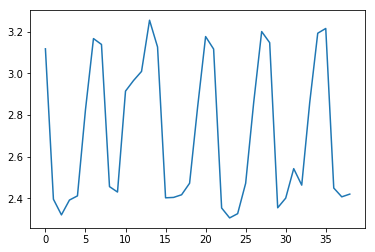

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.855273   
air_0164b9927d20bcc3_2017-04-23              1.492251   
air_0241aa3964b7f861_2017-04-23              2.347534   
air_0328696196e46f18_2017-04-23              2.049987   
air_034a3d5b40d5b1b1_2017-04-23              3.512922   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.393441  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.447096  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.459746  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.767799  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.546158

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/l3_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')